In [112]:
from bs4 import BeautifulSoup
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import re
from wmfdata import hive, charting
from wmfdata.charting import comma_fmt, pct_fmt
from wmfdata.utils import pct_str

%matplotlib inline
charting.set_mpl_style()

# Getting a list of participants into Hive

In [69]:
campaigns_html = requests.get("https://dashboard.wikiedu.org/campaigns").text
soup = BeautifulSoup(campaigns_html, "lxml")
campaign_urls = [tag.get("href") for tag in soup.select("td.title + td > a")]
campaign_csvs = ["https://dashboard.wikiedu.org" + slug for slug in campaign_urls]

# Have to remove visiting scholars since they are already experienced Wikimedians
campaign_csvs = [url for url in filter(lambda url: not re.search("visiting_scholars", url), campaign_csvs)]

rosters = []
for csv in campaign_csvs:
    rows = requests.get(csv).text.split("\n")
    rows.pop() # Remove empty last line
    rosters.append(pd.Series(rows))

In [71]:
participants = pd.concat(rosters, ignore_index=True)

In [76]:
filepath = "../data/wiki-education-foundation-participants.csv"
participants.to_csv(filepath, index=False)
hive.load_csv(
    filepath,
    field_spec="user_name string",
    db_name="neilpquinn",
    table_name="wiki_education_foundation_participants",
)

log4j:WARN No such property [maxBackupIndex] in org.apache.log4j.DailyRollingFileAppender.

Logging initialized using configuration in file:/etc/hive/conf.analytics-hadoop/hive-log4j.properties
Loading data to table neilpquinn.wiki_education_foundation_participants
OK
Time taken: 1.596 seconds



# New active editors

In [23]:
def bin_wikigroup(ser):
    enwiki = (ser == "enwiki")
    other = (ser != "enwiki")
    
    return pd.Categorical(
        ser
        .mask(enwiki, "enwiki")
        .mask(other, "other")
    )

new_active_editors_r = hive.run("""
select
    cohort,
    wiki,
    sum(cast(wefp.user_name is not null as int)) as wef_new_users,
    sum(cast(wefp.user_name is null as int)) as non_wef_new_users
from neilpquinn.new_editors ne
left join neilpquinn.wiki_education_foundation_participants wefp
on ne.user_name = wefp.user_name
where 1st_month_edits >= 5
group by cohort, wiki
"""
)

new_active_editors = (
    new_active_editors_r
    .assign(
        cohort=lambda df: pd.to_datetime(df["cohort"]),
        wikigroup=lambda df: bin_wikigroup(df["wiki"])
    )
)

In [314]:
(
    new_active_editors
    .query("cohort >= '2017-11-01'")
    .groupby("wikigroup").agg({
        "wef_new_users": "sum",
        "non_wef_new_users": "sum"
    })
    .div(12)
    .apply(round)
)

,non_wef_new_users,wef_new_users
wikigroup,,
enwiki,7484.0,1780.0
other,9807.0,0.0


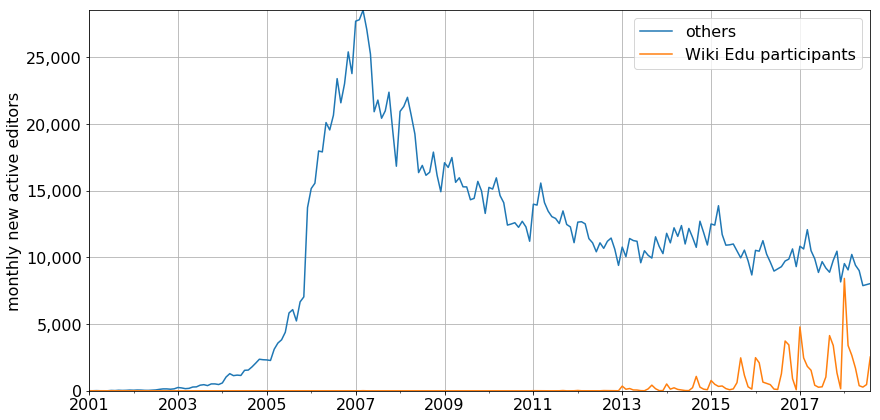

In [311]:
global_new_active_editors = new_active_editors.query("wikigroup == 'enwiki'").groupby("cohort").sum().iloc[:, [1, 0]]
global_new_active_editors.columns = ["others", "Wiki Edu participants"]
ax = global_new_active_editors.plot()
ax.set_ylabel("monthly new active editors")
ax.set_xlabel("")
ax.yaxis.set_major_formatter(comma_fmt);

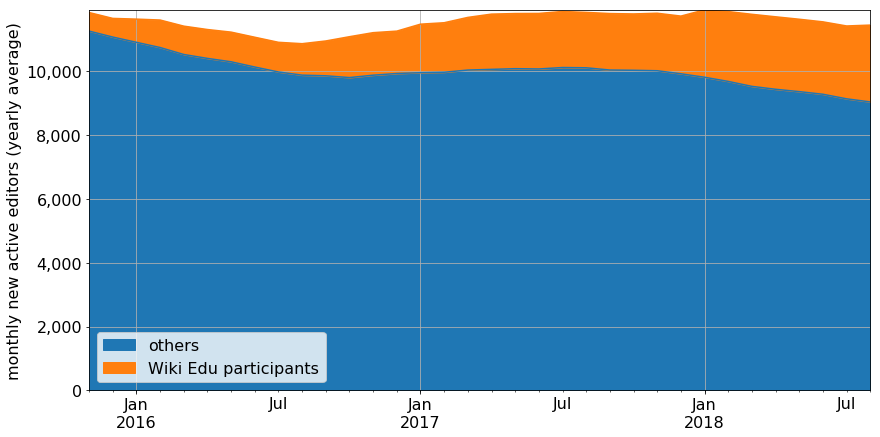

In [145]:
ax = global_new_active_editors.rolling(12).mean()["2015-11":].plot.area()
ax.set_ylabel("monthly new active editors (yearly average)")
ax.set_xlabel("")
ax.set_title("Yearly")
ax.yaxis.set_major_formatter(comma_fmt);

# English Wikipedia second-month new editor retention

In [43]:
new_editor_retention_r = hive.run("""
select
    cohort,
    if(wefp.user_name is null, "non_wef_participants", "wef_participants") as type,
    sum(cast(2nd_month_edits >= 1 as int)) / sum(cast(1st_month_edits >= 1 as int)) as new_user_retention
from neilpquinn.new_editors ne
left join neilpquinn.wiki_education_foundation_participants wefp
on ne.user_name = wefp.user_name
where wiki = "enwiki"
group by cohort, wefp.user_name is null
""")

In [288]:
new_editor_retention = (
    new_editor_retention_r
    .assign(cohort = lambda df: pd.to_datetime(df["cohort"]))
    .set_index(["cohort", "type"])
    .unstack()
    .fillna(0)
)

new_editor_retention.head()

new_user_retention                 
type       non_wef_participants wef_participants
cohort                                          
2001-01-01             0.625000              0.0
2001-02-01             0.500000              0.0
2001-03-01             0.611111              0.0
2001-04-01             0.400000              0.0
2001-05-01             0.600000              0.0

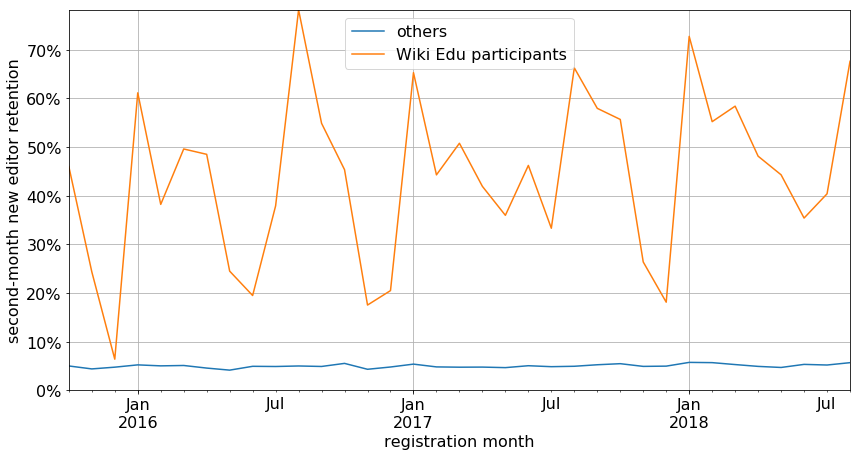

In [287]:
recent_retention = new_editor_retention["2015-10":]
recent_retention.columns = ["others", "Wiki Edu participants"]

ax = recent_retention.plot()
plt.ylim(0)
ax.set_ylabel("second-month new editor retention")
ax.set_xlabel("registration month")
ax.yaxis.set_major_formatter(pct_fmt);

# English Wikipedia sixth-month new editor retention

In [224]:
%%time
enwiki_new_eds_r = hive.run("""
select
    event_user_text as user_name,
    date_format(event_user_creation_timestamp, "yyyy-MM") as cohort,
    if(wefp.user_name is null, "non_wef", "wef") as type,
    sum(cast(datediff(event_timestamp, event_user_creation_timestamp) between 0 and 30 as int)) as mo_1_edits,
    sum(cast(datediff(event_timestamp, event_user_creation_timestamp) between 30 and 60 as int)) as mo_2_edits,
    sum(cast(datediff(event_timestamp, event_user_creation_timestamp) between 60 and 90 as int)) as mo_3_edits,
    sum(cast(datediff(event_timestamp, event_user_creation_timestamp) between 90 and 120 as int)) as mo_4_edits,
    sum(cast(datediff(event_timestamp, event_user_creation_timestamp) between 120 and 150 as int)) as mo_5_edits,
    sum(cast(datediff(event_timestamp, event_user_creation_timestamp) between 150 and 180 as int)) as mo_6_edits
from wmf.mediawiki_history mwh
left join neilpquinn.wiki_education_foundation_participants wefp
on
    mwh.event_user_text = wefp.user_name
where
    snapshot = "2018-12" and
    wiki_db = "enwiki" and
    event_entity = "revision" and
    event_type = "create" and
    not event_user_is_created_by_system and
    event_user_creation_timestamp between "2017-07" and "2018-07" and
    event_timestamp < date_add(event_user_creation_timestamp, 180)
group by event_user_text, event_user_creation_timestamp, wefp.user_name
""")

CPU times: user 13.2 s, sys: 92 ms, total: 13.3 s
Wall time: 2min 7s


In [226]:
enwiki_new_eds = enwiki_new_eds_r.query("mo_1_edits > 0")

In [290]:
retention = (
    enwiki_new_eds
    .iloc[:, 2:]
    .groupby("type")
    .agg(lambda x: (x > 0).sum() / len(x))
    .drop("mo_1_edits", axis=1)
    .transpose()
    .assign(month=[x for x in range(2, 7)])
    .set_index("month")
    .rename(columns={
        "wef": "Wiki Edu participants",
        "non_wef": "others"
    })
    
)

retention.applymap(pct_str)

type,others,Wiki Edu participants
month,,
2,5.4%,56.4%
3,3.6%,36.2%
4,2.9%,13.2%
5,2.4%,1.1%
6,2.1%,1.0%


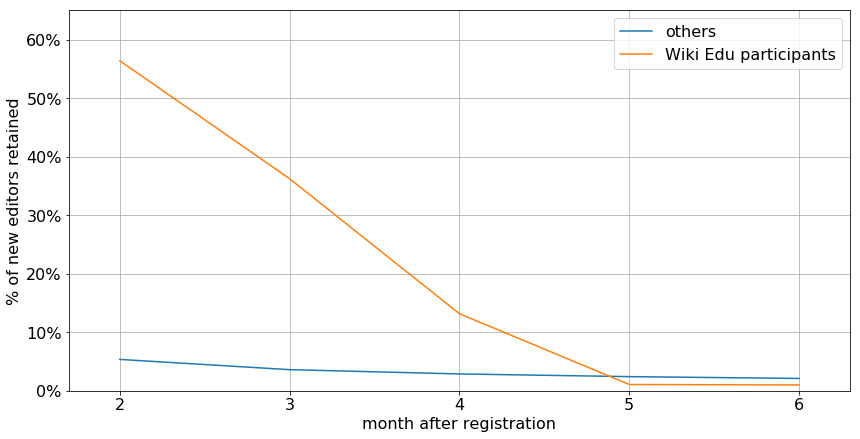

In [310]:
ax = retention.plot(ylim=(0, 0.65))

ax.xaxis.set_major_locator(mpl.ticker.IndexLocator(1, 0))
plt.xlabel("month after registration")
plt.ylabel("% of new editors retained")
plt.legend(title=None)
ax.yaxis.set_major_formatter(pct_fmt)
plt.margins(x=0.075)

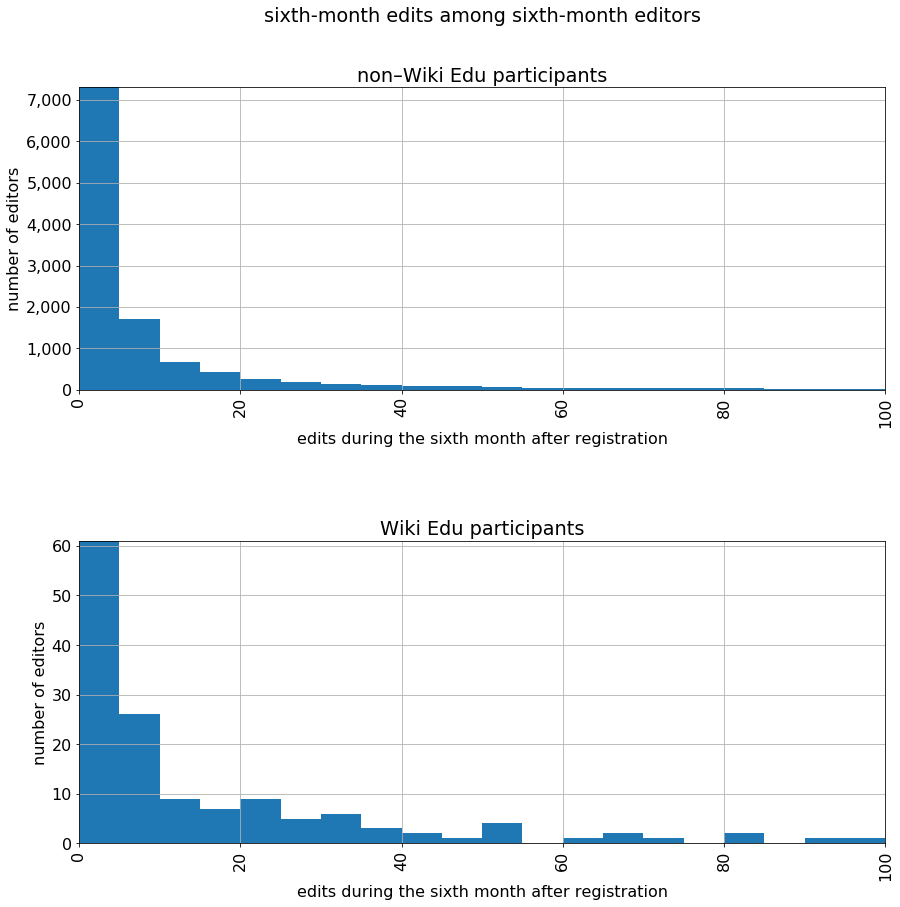

In [292]:
ax1, ax2 = enwiki_new_eds.query("mo_6_edits > 0").hist(
    column="mo_6_edits", 
    by="type",
    bins=[x for x in range(0, 105, 5)],
    layout=(2, 1), 
    figsize=(14, 14)
)
fig = plt.gcf()

fig.suptitle("sixth-month edits among sixth-month editors")
ax1.set_title("non–Wiki Edu participants")
ax2.set_title("Wiki Edu participants")

for ax in [ax1, ax2]:
    ax.set_xlabel("edits during the sixth month after registration")
    ax.set_ylabel("number of editors")
    ax.yaxis.set_major_formatter(comma_fmt)

Let's take 10 random sixth-month Wiki Edu editors and see if we can tell whether they're editing on their own now.

In [172]:
sixth_mo_eds.query("type == 'wef'").sample(10, random_state=708821419)

,user_name,cohort,type,1st_mo_edits,2nd_mo_edits,6th_mo_edits
230631,Historynerd6,2017-11,wef,8,0,9
365354,Mgmoran,2017-11,wef,7,0,12
158265,Drax Gon Give It To Ya,2017-08,wef,25,44,2
314476,Kylaj,2017-09,wef,27,45,28
49076,Are2160657,2017-09,wef,10,0,3
620621,ZenZorro,2018-02,wef,23,3,8
565308,Tlevenda,2018-05,wef,6,0,28
269145,Jerryshen,2017-08,wef,27,110,22
183616,Farfallepuree,2017-11,wef,18,8,21
206371,Gkachuck,2017-05,wef,45,11,20


* **Historynerd6**: Participated in a second course.
* **Mgmoran**: Participated in a second course.
* **Drax Gon Give It To Ya**: Returned a year after course to write a second article. 50% probability of participating in a second course, 50% of being genuinely retained.
* **Kylaj**: Participated in a second course.
* **Are2160657**: Returned about six months for one session of small improvements.
* **ZenZorro**: Genuinely retained—9 session since course end: adding content, participating on talk pages.
* **Tlevenda**: Returned to write a couple of articles on Indiana newspapers—likely independent of course.
* **Jerryshen**: Returned the month after course to shepherd assigned article through good article review, and once ~6 months later to fix a typo.
* **Farfallepuree**: Participated in a second course
* **Gkachuck**: Participated in a second course

So that's 5.5 who participated in a second course,  2 who returned to make small improvements, and 2.5 who are genuinely retained.